# [1]. Reading Data

In [1]:

import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
import math
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

D:\conda\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('data.sqlite') 
df = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 
df.shape


(103040, 12)

In [3]:
text=df['CleanedText']
label=df['Score']
from sklearn.model_selection import train_test_split
x,x_test,y,y_test=train_test_split(text,label,test_size=0.2,random_state=0, stratify=label)
x_train,x_cv,y_train,y_cv=train_test_split(x,y,test_size=0.25, random_state=0, stratify=y)
x_train.shape

(61824,)

### BOW and TFIDF vectorizers.

In [4]:
vect=CountVectorizer().fit(x_train)
train_cnt=vect.transform(x_train)
cv_cnt=vect.transform(x_cv)
test_cnt=vect.transform(x_test)
idf=TfidfVectorizer().fit(x_train)
train_tf=idf.transform(x_train)
test_tf=idf.transform(x_test)
cv_tf=idf.transform(x_cv)

### AVG W2V Vectorizers.

In [7]:
list_of_words=[]
for x in x_train.values:
    list_of_words.append(x.split())
    
w2v_model=Word2Vec(list_of_words, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

    
test_word_list=[]
for x in x_test.values:
    test_word_list.append(x.split())
    
cv_word_list=[]
for x in x_cv.values:
    cv_word_list.append(x.split())
    
train_w2v=[];
for x in tqdm(list_of_words):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v.append(sent_vec)
    
    
cv_w2v=[];
for x in tqdm(cv_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2v.append(sent_vec)

test_w2v=[]
for x in tqdm(test_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v.append(sent_vec)
    

100%|███████████████████████████████████| 20608/20608 [00:50<00:00, 407.32it/s]


### TFIDF W2V Vectorizers

In [8]:
model = TfidfVectorizer()
model.fit_transform(x_train.values)

dicti= dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() 

train_df= [];
row=0;
for sent in tqdm(list_of_words): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
    
            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_df.append(sent_vec)
    row += 1
    
tfidf_feat = model.get_feature_names() 

test_df= []; 
row=0;
for sent in tqdm(test_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_df.append(sent_vec)
    row += 1
    
    
cv_df= []; 
row=0;
for sent in tqdm(cv_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_df.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 20608/20608 [13:30<00:00, 25.42it/s]


## Function for finding hyperparameter with highest AUC

In [16]:
def hyperSearch(train,cv,y_train,y_cv,lst):
    roc_scores=[]
    roc_t=[]
    k= [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]
    for l in lst:
        for i in k:
            clf=CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge', penalty=l, alpha=i), cv=10, method='sigmoid')
            clf.fit(train,y_train)
            pred=clf.predict_proba(cv)[:,1]
            pred_train=clf.predict_proba(train)[:,1]
            roc=roc_auc_score(y_cv,pred)
            roct=roc_auc_score(y_train,pred_train)
            roc_scores.append(roc)
            roc_t.append(roct)
        a=[math.log10(y) for y in k]
        plt.plot(a,roc_scores,label='CV data for reg '+l)
        plt.plot(a,roc_t, label='Training data for reg '+l)
        plt.xlabel('log(alpha)')
        plt.ylabel('AUC Scores')
        plt.title('Error Plot')
        plt.legend()
        roc_scores=[]
        roc_t=[]
    plt.show()



#### SGDClassifier is an linear classifier and when loss function is' hinge', it implements SVM model.


#### Since, SVM only cares about hyperplane with optimal margin and assigns class label on basis of distance of point from hyperplane( decision_function) and thus, doesn't provides a way to calculate probabilities.

#### For getting probability, CalibratedClassifierCV is fitted on output of SGDClassifier and uses platt scaling to output probabilities i.e., P(class/input)=1/(1+exp(A*f(input)+B)), where f(input) is o/p of decision_function and A, B are optimized parameter results from SVM fitting.


### Function to plot ROC curves.

In [14]:
def rocPlot(test_data, train_data, y_train, y_test):
    pred_proba = clf.predict_proba(test_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_test, pred_proba)
    roc_auc=roc_auc_score(y_test, pred_proba)
    plt.plot(fpr, tpr, label='AUC= %0.3f for test set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    pred_probat = clf.predict_proba(train_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_train, pred_probat)
    roc_auc=roc_auc_score(y_train, pred_probat)
    plt.plot(fpr, tpr, label='AUC= %0.3f for training set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curves of train and test data')
    plt.legend(loc="lower right")
    plt.show()

### Function to plot confusion matrix

In [15]:
def con_mx(target1, predict1, target2, predict2):
    cm = confusion_matrix(target1, predict1)
    cm2=confusion_matrix(target2, predict2)
    cm = pd.DataFrame(cm)
    cm2 = pd.DataFrame(cm2)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm2.index.name = 'Actual'
    cm2.columns.name = 'Predicted'
    fig, (ax1,ax2)= plt.subplots(1,2)
    ax1.set_title('Test Dataset')
    ax2.set_title('Training Dataset')
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    sns.heatmap(cm2, annot=True, fmt='d', ax=ax2)


# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

#### To find optimal value of alpha and best penalty 

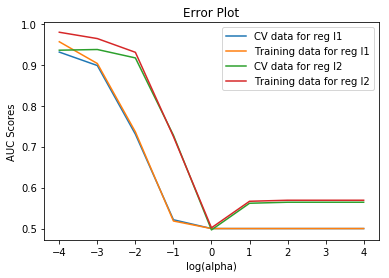

In [32]:
hyperSearch(train_cnt,cv_cnt,y_train,y_cv,['l1','l2'])

#### Fitting SGDClassifier on training data followed by CalibratedClassifierCV on top of it with optimal parameters.

In [40]:
clf=CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge', penalty='l2', alpha=0.001), method='sigmoid')
clf.fit(train_cnt,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv='warn', method='sigmoid')

#### ROC plot for training and test data

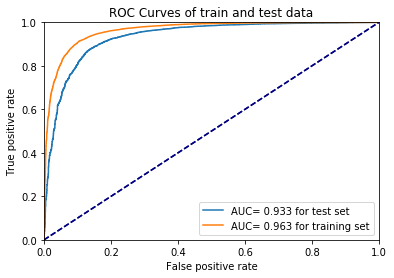

In [46]:
rocPlot(test_cnt, train_cnt, y_train, y_test)

#### Confusion matrix plot for training and test data.

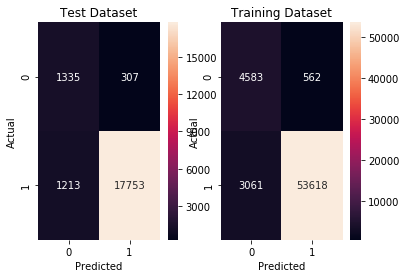

In [48]:
pred=clf.predict(test_cnt)
pred_train=clf.predict(train_cnt)
con_mx(pred, y_test, pred_train, y_train)

#### Top 10 features of positive class

In [47]:
fun=SGDClassifier(loss='hinge', penalty='l2', alpha=0.001)
fun.fit(train_cnt,y_train)
coef_l2=fun.coef_[0]
features_10=np.argpartition(coef_l2,-10)[-10:] #only to sort incides of top 10 weights
for i in features_10:
    print(vect.get_feature_names()[i], end=', ')

pleased, loves, best, wonderful, highly, perfect, great, excellent, awesome, delicious, 

#### Top 10 features of negative class

In [48]:
neg_10=np.argpartition(coef_l2,10)[:10] #indices of top 10 features from negative class
for i in neg_10:
    print(vect.get_feature_names()[i], end=', ')

horrible, worst, disappointing, unfortunately, awful, disappointed, return, disappointment, terrible, threw, 

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

#### To find optimal value of alpha and best penalty 

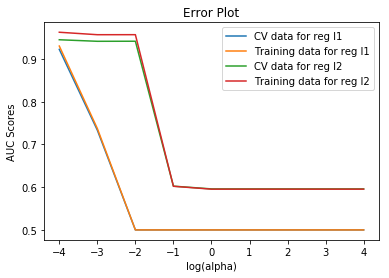

In [40]:
hyperSearch(train_tf,cv_tf,y_train,y_cv,['l1','l2'])

#### Fitting SGDClassifier on training data followed by CalibratedClassifierCV on top of it with optimal parameters.

In [51]:
clf=CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001), method='sigmoid')
clf.fit(train_tf,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv='warn', method='sigmoid')

#### ROC plot for training and test data

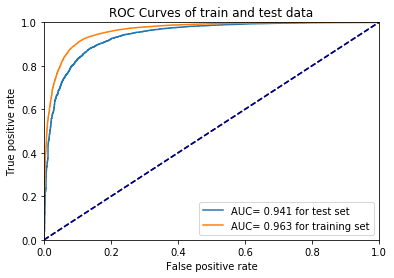

In [52]:
rocPlot(test_tf, train_tf, y_train, y_test)

#### Confusion matrix plot for training and test data.

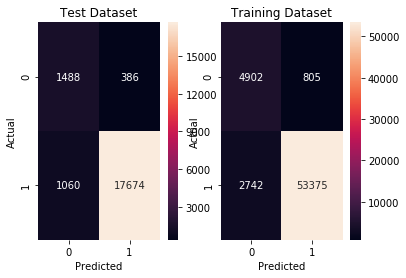

In [53]:
pred=clf.predict(test_tf)
pred_train=clf.predict(train_tf)
con_mx(pred, y_test, pred_train, y_train)

#### Top 10 features of positive class

In [49]:
fun=SGDClassifier(loss='hinge', penalty='l2', alpha=0.001)
fun.fit(train_tf,y_train)
coef_l2=fun.coef_[0]
features_10=np.argpartition(coef_l2,-10)[-10:] #only to sort incides of top 10 weights
for i in features_10:
    print(idf.get_feature_names()[i], end=', ')

highly, perfect, excellent, loves, wonderful, love, delicious, great, best, good, 

#### Top 10 features of negative class

In [50]:
neg_10=np.argpartition(coef_l2,10)[:10] #indices of top 10 features from negative class
for i in neg_10:
    print(idf.get_feature_names()[i], end=', ')

terrible, horrible, worst, awful, threw, return, waste, disappointed, money, not, 

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

#### To find optimal value of alpha and best penalty 

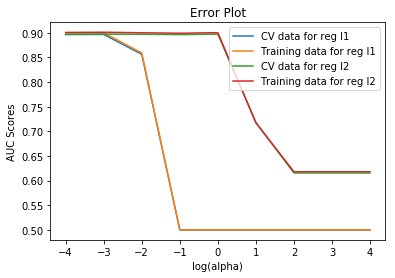

In [54]:
hyperSearch(train_w2v,cv_w2v,y_train,y_cv,['l1','l2'])

#### Fitting SGDClassifier on training data followed by CalibratedClassifierCV on top of it with optimal parameters.

In [55]:
clf=CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001), method='sigmoid')
clf.fit(train_w2v,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv='warn', method='sigmoid')

#### ROC plot for training and test data

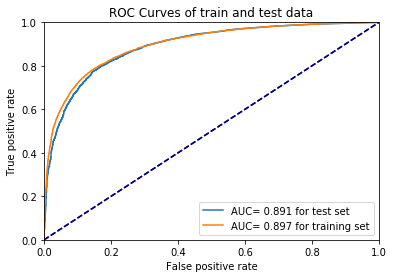

In [56]:
rocPlot(test_w2v, train_w2v, y_train, y_test)

#### Confusion matrix plot for training and test data.

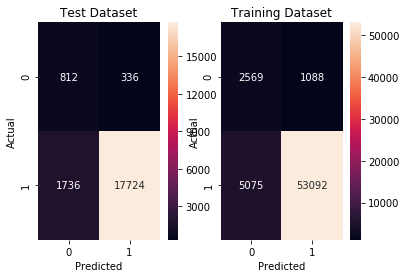

In [57]:
pred=clf.predict(test_w2v)
pred_train=clf.predict(train_w2v)
con_mx(pred, y_test, pred_train, y_train)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

#### To find optimal value of alpha and best penalty 

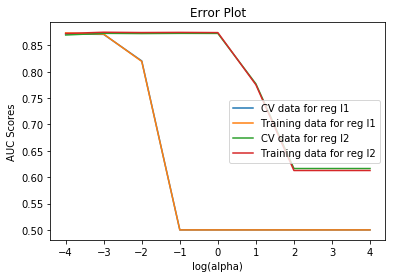

In [58]:
hyperSearch(train_df,cv_df,y_train,y_cv,['l1','l2'])

#### Fitting SGDClassifier on training data followed by CalibratedClassifierCV on top of it with optimal parameters.

In [59]:
clf=CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001), method='sigmoid')
clf.fit(train_df,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv='warn', method='sigmoid')

#### ROC plot for training and test data

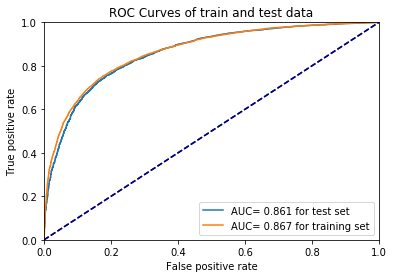

In [60]:
rocPlot(test_df, train_df, y_train, y_test)

#### Confusion matrix plot for training and test data.

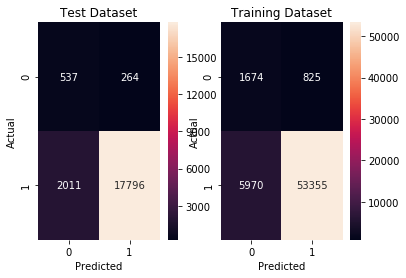

In [61]:
pred=clf.predict(test_df)
pred_train=clf.predict(train_df)
con_mx(pred, y_test, pred_train, y_train)

## SVM with RBF Kernel

In [18]:
dm=df.head(35000)
data=dm['CleanedText']
target=dm['Score']
from sklearn.model_selection import train_test_split
train,test_nw,tgt,tst_tgt=train_test_split(data,target,test_size=0.2,random_state=0, stratify=target)
train_nw,cv_nw,trn_tgt,cv_tgt=train_test_split(train,tgt,test_size=0.25,random_state=0,stratify=tgt)

Taking only 35K datapoints are RBF kernel is computationally expensive.

### Conversion of raw datapoints into BOW, TFIDF, AVG W2V and TFIDF W2V vectorizers respectively.

In [19]:
vec=CountVectorizer(min_df=10, max_features=500)
cnt=vec.fit(train_nw)
train_rbf=cnt.transform(train_nw)
cv_rbf=cnt.transform(cv_nw)
test_rbf=cnt.transform(test_nw)
dx=TfidfVectorizer(min_df=10, max_features=500)
dft=dx.fit(train_nw)
train_id=dft.transform(train_nw)
cv_id=dft.transform(cv_nw)
test_id=dft.transform(test_nw)

In [20]:
std=StandardScaler(with_mean=False).fit(train_rbf)
train_rb=std.transform(train_rbf)
cv_rb=std.transform(cv_rbf)
test_rb=std.transform(test_rbf)
std_tf=StandardScaler(with_mean=False).fit(train_id)
train_rbf_tf=std_tf.transform(train_id)
cv_rbf_tf=std_tf.transform(cv_id)
test_rbf_tf=std_tf.transform(test_id)

D:\conda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\conda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\conda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\conda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
list_of_words=[]
for x in train_nw.values:
    list_of_words.append(x.split())
    
w2v_model=Word2Vec(list_of_words, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

    
test_word=[]
for x in test_nw.values:
    test_word.append(x.split())
    
cv_word=[]
for x in cv_nw.values:
    cv_word.append(x.split())
    
train_w2v_rbf=[];
for x in tqdm(list_of_words):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v_rbf.append(sent_vec)
    
    
cv_w2v_rbf=[];
for x in tqdm(cv_word):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2v_rbf.append(sent_vec)

test_w2v_rbf=[]
for x in tqdm(test_word):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v_rbf.append(sent_vec)
    

100%|█████████████████████████████████████| 7000/7000 [00:10<00:00, 657.49it/s]


In [9]:
vector = TfidfVectorizer()
vector.fit_transform(train_nw.values)

dicti= dict(zip(vector.get_feature_names(), list(vector.idf_)))

tfidf_feat = vector.get_feature_names() 

train_rbf_df= [];
row=0;
for sent in tqdm(list_of_words): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
    
            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_rbf_df.append(sent_vec)
    row += 1
    


test_rbf_df= []; 
row=0;
for sent in tqdm(test_word):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_rbf_df.append(sent_vec)
    row += 1
    
    
cv_rbf_df= []; 
row=0;
for sent in tqdm(cv_word):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_rbf_df.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 7000/7000 [01:52<00:00, 62.47it/s]


### Function to find optimal value of C for SVM with RBF kernel 

In [10]:
def Search(train,cv,y_train,y_cv):
    roc_scores=[]
    roc_t=[]
    k= [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]
    for i in k:
        clf=SVC(C=i, gamma='scale', probability=True)
        clf.fit(train,y_train)
        pred=clf.predict_proba(cv)[:,1]
        pred_train=clf.predict_proba(train)[:,1]
        roc=roc_auc_score(y_cv,pred)
        roct=roc_auc_score(y_train,pred_train)
        roc_scores.append(roc)
        roc_t.append(roct)
    a=[math.log10(y) for y in k]
    plt.plot(a,roc_scores,label='CV data')
    plt.plot(a,roc_t, label='Training data ')
    plt.xlabel('log(C)')
    plt.ylabel('AUC Scores')
    plt.title('Error Plot')
    plt.legend()
    plt.show()



## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

#### To find optimal value of alpha and best penalty 

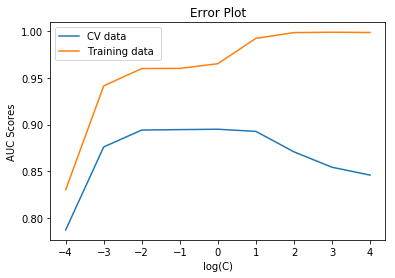

Wall time: 1h 27min 48s


In [8]:
%%time
Search(train_rb,cv_rb,trn_tgt,cv_tgt)

In [23]:
clf=SVC(C=10, gamma='scale', probability=True)
clf.fit(train_rb,trn_tgt)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### ROC plot for training and test data

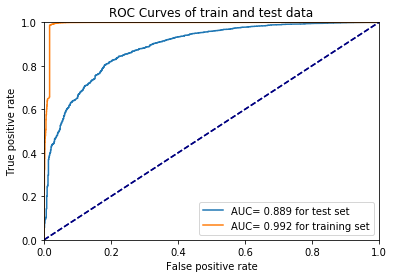

In [24]:
rocPlot(test_rb, train_rb, trn_tgt, tst_tgt)

#### Confusion matrix plot for training and test data.

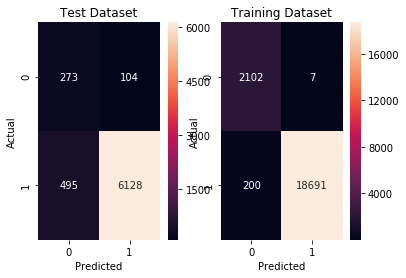

In [27]:
pred=clf.predict(test_rb)
pred_train=clf.predict(train_rb)
con_mx(pred, tst_tgt, pred_train, trn_tgt)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

#### To find optimal value of alpha and best penalty 

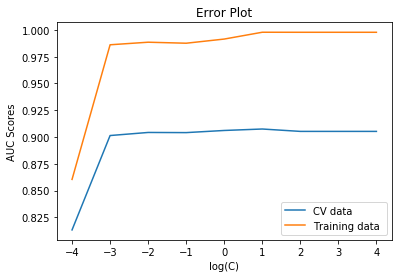

Wall time: 1h 27min 56s


In [14]:
%%time
Search(train_rbf_tf,cv_rbf_tf,trn_tgt,cv_tgt)

In [31]:
clf=SVC(C=10, gamma='scale', probability=True)
clf.fit(train_rbf_tf,trn_tgt)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### ROC plot for training and test data

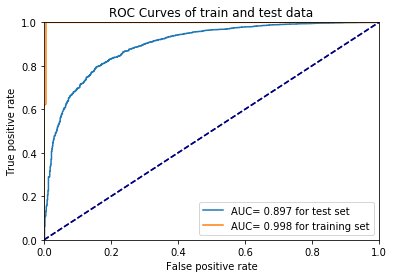

In [32]:
rocPlot(test_rbf_tf, train_rbf_tf, trn_tgt, tst_tgt)

#### Confusion matrix plot for training and test data.

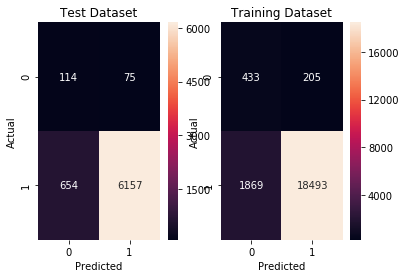

In [33]:
pred=clf.predict(test_rbf)
pred_train=clf.predict(train_rbf)
con_mx(pred, tst_tgt, pred_train, trn_tgt)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

#### To find optimal value of alpha and best penalty 

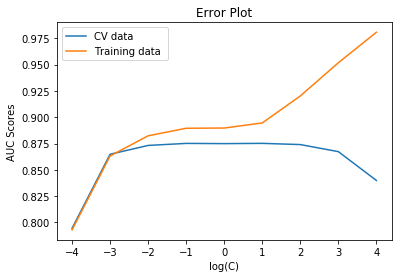

Wall time: 1h 9min


In [13]:
%%time
Search(train_w2v_rbf,cv_w2v_rbf,trn_tgt,cv_tgt)

In [34]:
clf=SVC(C=100, gamma='scale', probability=True)
clf.fit(train_w2v_rbf,trn_tgt)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### ROC plot for training and test data

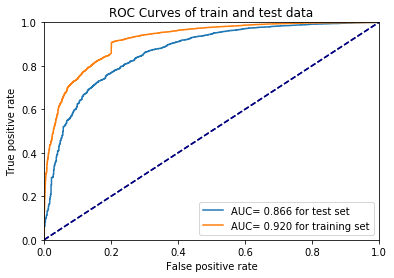

In [35]:
rocPlot(test_w2v_rbf, train_w2v_rbf, trn_tgt, tst_tgt)

#### Confusion matrix plot for training and test data.

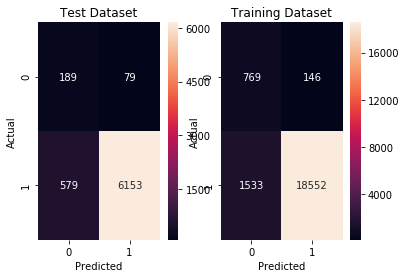

In [36]:
pred=clf.predict(test_w2v_rbf)
pred_train=clf.predict(train_w2v_rbf)
con_mx(pred, tst_tgt, pred_train, trn_tgt)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

#### To find optimal value of alpha and best penalty 

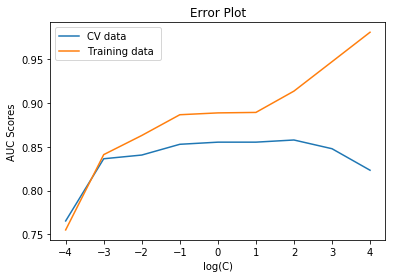

Wall time: 1h 10min 42s


In [15]:
%%time
Search(train_rbf_df,cv_rbf_df,trn_tgt,cv_tgt)

In [37]:
clf=SVC(C=100, gamma='scale', probability=True)
clf.fit(train_rbf_df,trn_tgt)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### ROC plot for training and test data

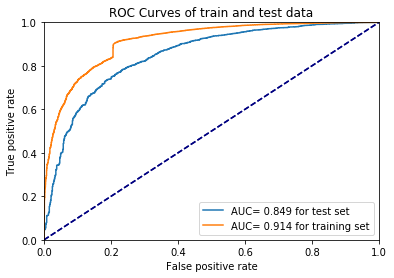

In [38]:
rocPlot(test_rbf_df, train_rbf_df, trn_tgt, tst_tgt)

#### Confusion matrix plot for training and test data.

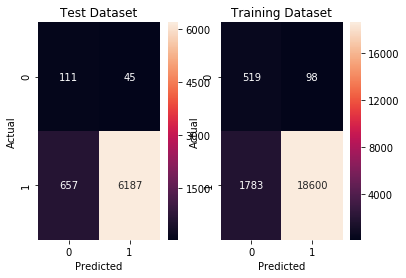

In [39]:
pred=clf.predict(test_rbf_df)
pred_train=clf.predict(train_rbf_df)
con_mx(pred, tst_tgt, pred_train, trn_tgt)

# [6] Conclusions

In [57]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Vectorizer", "Regularizer", "Hyper Parameter","Kernel" ,"AUC"]
x.add_row(["BOW", "l2", 0.001,"linear", 0.933])
x.add_row(["TF-IDF","l2", 0.0001,"linear", 0.941])
x.add_row(["AVG W2V","l2", 0.0001,"linear" ,0.891])
x.add_row(["TFIDF W2V","l2", 0.0001,"linear", 0.861])
x.add_row(["BOW", "l2", 10,"RBF", 0.889])
x.add_row(["TF-IDF","l2", 10,"RBF", 0.897])
x.add_row(["AVG W2V","l2", 100,"RBF" ,0.866])
x.add_row(["TFIDF W2V","l2", 100,"RBF", 0.849])
print(x)

+------------+-------------+-----------------+--------+-------+
| Vectorizer | Regularizer | Hyper Parameter | Kernel |  AUC  |
+------------+-------------+-----------------+--------+-------+
|    BOW     |      l2     |      0.001      | linear | 0.933 |
|   TF-IDF   |      l2     |      0.0001     | linear | 0.941 |
|  AVG W2V   |      l2     |      0.0001     | linear | 0.891 |
| TFIDF W2V  |      l2     |      0.0001     | linear | 0.861 |
|    BOW     |      l2     |        10       |  RBF   | 0.889 |
|   TF-IDF   |      l2     |        10       |  RBF   | 0.897 |
|  AVG W2V   |      l2     |       100       |  RBF   | 0.866 |
| TFIDF W2V  |      l2     |       100       |  RBF   | 0.849 |
+------------+-------------+-----------------+--------+-------+


 SVM is implemented for linear as well as RBF kernel for all four vectorizers with optimal value of hyperparameter and further ROC curve and confusion matrix plots for train and test data.

AUC for rbf kernel is low because we have just taken 35k datapoints.
